## Carregando os Dados

In [1]:
from pandas import read_csv
data = read_csv('./glass.csv')
X = data.drop("Type",1)
y = data["Type"].values

In [2]:
import pandas as pd
results = pd.DataFrame(index=['SVM', 'KNN', 'Naive Bayes', 'Decision Tree'])

## EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data['Type'])
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
data['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

Podemos ver que o nosso dataset é bastante desbalanceado

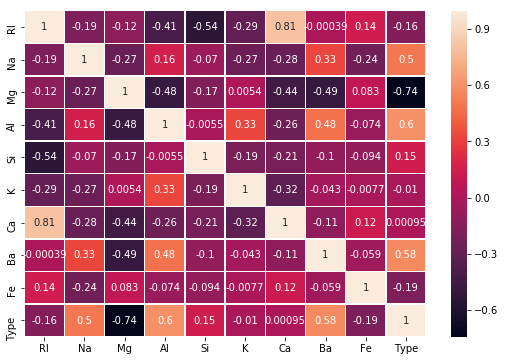

In [5]:
corr = data.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

Essa visualização é interessante para uma análise mais profunda, porém
estamos mais interessados apenas no módulo das correlações

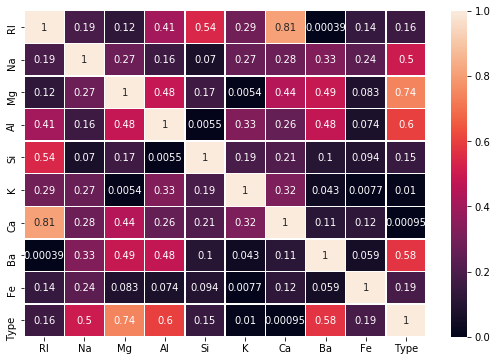

In [6]:
corr = abs(corr)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

A partir da matriz de correlação podemos concluir alguns fatos:
* Existe baixa correlação entre a quantidade de Cálcio e tipo 
* Existe baixa correlação entre a quantidade de Potássio e tipo
* Existem muitos fatores com correlação moderada ou elevada
* Por consequência um PCA pode ser interessante

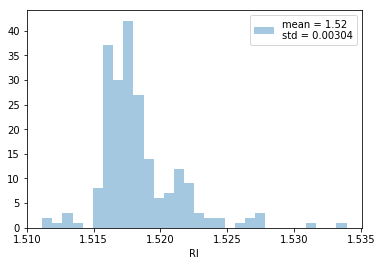

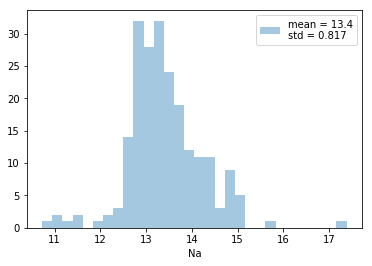

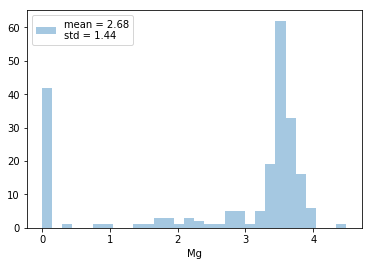

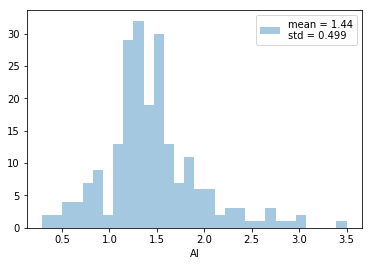

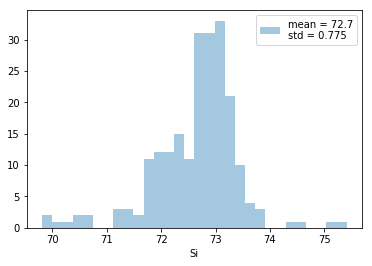

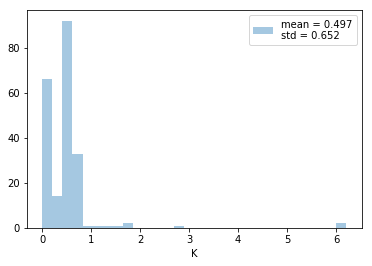

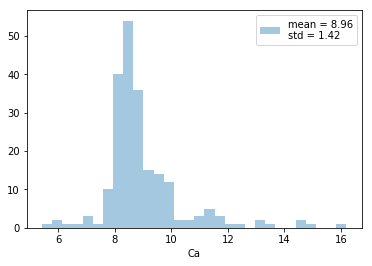

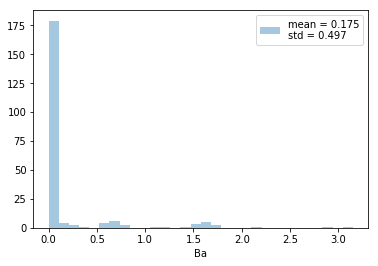

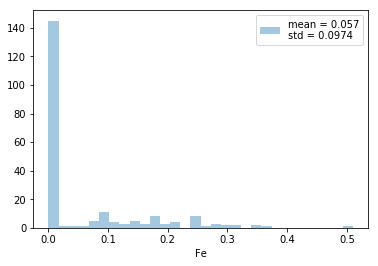

In [7]:
for feat in X:
    mean = X[feat].mean()
    std = X[feat].std()
    sns.distplot(X[feat], kde= False, label=f'mean = {mean:.3}\nstd = {std:.3}', bins=30)
    plt.legend(loc='best')
    plt.show()

* Os dados têm escalas bem diferentes, portanto é interessante fazer um scaling deles
* A maioria das features apresenta outliers, então é melhor usar um StandardScaler

## Primeiro Teste dos Modelos

In [8]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [9]:
classifiers = { 'SVM':SVC(gamma='auto'), 
                'KNN': KNeighborsClassifier(n_neighbors=3),
                'Naive Bayes':GaussianNB(),
                'Decision Tree': DecisionTreeClassifier(random_state=0)}

In [10]:
def test_classifiers(X, y, classifiers, case):
  global results
  results[case] = pd.Series([])
  for name, clf in classifiers.items():
      cv = cross_val_score(clf, X, y, cv=5)
      media = np.mean(cv)
      std = np.std(cv)
      print(f'{name} conseguiu acurácia de {media} e desvio padrão de {std}')
      results[case][name] = media

In [11]:
test_classifiers(X, y, classifiers, 'standard')

SVM conseguiu acurácia de 0.5924915265612941 e desvio padrão de 0.10546929173346412
KNN conseguiu acurácia de 0.6050597335481057 e desvio padrão de 0.07194859786694979
Naive Bayes conseguiu acurácia de 0.3311956777073056 e desvio padrão de 0.12349459392313786
Decision Tree conseguiu acurácia de 0.5920507399577166 e desvio padrão de 0.06048704491552701


## Solucão Ingênua
Vamos apenas remover os dois features com correlação baixa demais (menor ou igual a 1% com o target) 

In [12]:
X_restricted = X.drop(['Ca', 'K'], axis=1)

In [13]:
test_classifiers(X_restricted, y, classifiers, 'naive')

SVM conseguiu acurácia de 0.525599348971442 e desvio padrão de 0.10313521256260154
KNN conseguiu acurácia de 0.6039821806100877 e desvio padrão de 0.0769905008926757
Naive Bayes conseguiu acurácia de 0.1974398469747307 e desvio padrão de 0.096562491608475
Decision Tree conseguiu acurácia de 0.5609785563273935 e desvio padrão de 0.07353786100307096


## Aplicando o PCA

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
from pandas import DataFrame
DataFrame(pca.explained_variance_.round(2), index=["P" + str(i) for i in range(1,10)], columns=["Explained Variance"]).T

,P1,P2,P3,P4,P5,P6,P7,P8,P9
Explained Variance,3.0,1.66,0.68,0.64,0.21,0.1,0.01,0.0,0.0


In [16]:
DataFrame(pca.explained_variance_ratio_.round(2), index = ["P" + str(i) for i in range(1,10)], columns=["Explained Variance Ratio"]).T

,P1,P2,P3,P4,P5,P6,P7,P8,P9
Explained Variance Ratio,0.48,0.26,0.11,0.1,0.03,0.02,0.0,0.0,0.0


Podemos observar que três componentes explicam 0% da variância, e podem portanto ser eliminados sem perda na capacidade preditiva.

Também é legal notar que os 4 primeiros componentes explicam 95% da variância dos dados.

In [17]:
components_applied = DataFrame(pca.transform(X))
components_applied.columns = ["P" + str(i) for i in range(1,10)]
components_applied.round(2).head() 

,P1,P2,P3,P4,P5,P6,P7,P8,P9
0,-1.43,-1.10,-1.07,-0.16,0.14,-0.08,-0.07,0.01,-0.0
1,-1.44,0.34,-0.28,-0.29,-0.19,-0.05,-0.04,-0.02,-0.0
2,-1.43,0.35,0.14,-0.32,0.02,-0.19,-0.05,0.02,-0.0
3,-1.26,-0.25,0.06,0.02,0.00,0.02,-0.05,0.09,-0.0
4,-1.31,-0.02,0.36,-0.28,-0.07,0.08,-0.05,-0.00,-0.0


In [18]:
from pandas import concat
from IPython.display import display

for p in components_applied.columns:
    
    new_df = X.copy()
    new_df[p] = components_applied[p]
    display(DataFrame(new_df.corr().round(2)[p]).drop(p,0).T)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P1,0.53,0.04,-0.87,0.16,-0.02,-0.21,0.83,0.27,0.02


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P2,-0.65,0.63,-0.48,0.67,0.32,0.21,-0.56,0.58,-0.22


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P3,-0.37,-0.66,-0.07,0.09,0.74,0.28,-0.05,-0.22,0.06


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P4,0.08,-0.34,-0.05,0.44,-0.59,0.83,-0.03,0.16,0.09


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P5,0.11,-0.22,0.02,0.29,-0.06,-0.36,-0.02,0.63,0.13


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P6,0.19,-0.01,-0.01,-0.5,0.02,0.13,-0.01,0.36,-0.0


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P7,-0.01,-0.0,-0.0,-0.01,-0.01,-0.01,-0.0,-0.02,0.96


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P8,-0.05,-0.02,-0.01,-0.03,-0.02,-0.02,-0.01,-0.03,-0.07


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P9,-0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pca = PCA(n_components=6)
X_transformed = DataFrame(pca.fit_transform(X)) 

In [20]:
test_classifiers(X_transformed, y, classifiers, 'standard_pca')

SVM conseguiu acurácia de 0.6292873921943689 e desvio padrão de 0.08314822803616308
KNN conseguiu acurácia de 0.6005142790026512 e desvio padrão de 0.07053130105444379
Naive Bayes conseguiu acurácia de 0.5292350414443437 e desvio padrão de 0.06350774992484741
Decision Tree conseguiu acurácia de 0.6010792308466727 e desvio padrão de 0.09601262687524185


In [21]:
results

,standard,naive,standard_pca
SVM,0.592492,0.525599,0.629287
KNN,0.605060,0.603982,0.600514
Naive Bayes,0.331196,0.197440,0.529235
Decision Tree,0.592051,0.560979,0.601079


Vemos uma melhora de desempenho de todos os classificadores, principalmente do Naive Bayes, 
pois reduzimos a redundância e correlação entre as features

In [22]:
pca = PCA(n_components=4)
X_transformed = pca.fit_transform(X) 
test_classifiers(X_transformed, y, classifiers, 'half_components')

SVM conseguiu acurácia de 0.6150760092620559 e desvio padrão de 0.08835244302143418
KNN conseguiu acurácia de 0.6051607436491158 e desvio padrão de 0.08061229155653335
Naive Bayes conseguiu acurácia de 0.5141145676029397 e desvio padrão de 0.06136290824358418
Decision Tree conseguiu acurácia de 0.5586070002349073 e desvio padrão de 0.08385545891265166


Aqui é interessante notar que estamos usando menos da meatade das features e tendo um desempenho 
semelhante ou melhor que o que tinhamos ao usar todos elas.

Uma outra técnica de seleção de features é remover features com baixa correlação com o primeiro
componente do PCA, vamos ver que resultados nós conseguiriamos a partir disso

In [23]:
X_restricted = X.drop(['Fe', 'Si', 'Na'], axis=1)
test_classifiers(X_restricted, y, classifiers, 'correlated_pc')

SVM conseguiu acurácia de 0.5968898285177355 e desvio padrão de 0.09602634516236537
KNN conseguiu acurácia de 0.6107884492768214 e desvio padrão de 0.1087951045352851
Naive Bayes conseguiu acurácia de 0.3908876136783113 e desvio padrão de 0.08498882660365276
Decision Tree conseguiu acurácia de 0.6083616899895969 e desvio padrão de 0.03314315146879812


In [24]:
results

,standard,naive,standard_pca,half_components,correlated_pc
SVM,0.592492,0.525599,0.629287,0.615076,0.596890
KNN,0.605060,0.603982,0.600514,0.605161,0.610788
Naive Bayes,0.331196,0.197440,0.529235,0.514115,0.390888
Decision Tree,0.592051,0.560979,0.601079,0.558607,0.608362


Temos um resultado bem melhor que a nossa solução ingênua

## Normalizando os Dados

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [26]:
test_classifiers(X_scaled, y, classifiers, 'scaled')

SVM conseguiu acurácia de 0.6605745159233531 e desvio padrão de 0.08693991755213408
KNN conseguiu acurácia de 0.6638353636028054 e desvio padrão de 0.05246078549043214
Naive Bayes conseguiu acurácia de 0.3161956777073056 e desvio padrão de 0.1417278556228799
Decision Tree conseguiu acurácia de 0.5920507399577166 e desvio padrão de 0.06048704491552701


## Dados Normalizados + PCA

In [27]:
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
DataFrame(pca.explained_variance_ratio_.round(2), index = ["P" + str(i) for i in range(1,10)], columns=["Explained Variance Ratio"]).T

,P1,P2,P3,P4,P5,P6,P7,P8,P9
Explained Variance Ratio,0.28,0.23,0.16,0.13,0.1,0.06,0.04,0.01,0.0


In [29]:
components_applied = DataFrame(pca.transform(X_scaled))
components_applied.columns = ["P" + str(i) for i in range(1,10)]
components_applied.round(2).head() 

,P1,P2,P3,P4,P5,P6,P7,P8,P9
0,1.15,-0.53,-0.37,1.73,-0.25,0.34,-0.40,-0.20,0.02
1,-0.57,-0.76,-0.56,0.76,-0.26,-0.12,-0.02,-0.28,-0.01
2,-0.94,-0.93,-0.55,0.21,-0.24,0.13,-0.37,-0.10,0.02
3,-0.14,-0.96,-0.12,0.42,-0.48,0.29,-0.05,-0.00,0.09
4,-0.35,-1.09,-0.49,0.07,-0.43,0.30,0.16,-0.19,0.00


In [30]:
for p in components_applied.columns:
    
    new_df = X.copy()
    new_df[p] = components_applied[p]
    display(DataFrame(new_df.corr().round(2)[p]).drop(p,0).T)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P1,0.86,-0.41,0.18,-0.68,-0.36,-0.35,0.78,-0.4,0.29


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P2,0.41,0.39,-0.85,0.42,-0.22,-0.22,0.49,0.69,-0.09


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P3,0.1,-0.46,0.01,0.39,-0.54,0.79,-0.0,0.09,0.34


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P4,0.16,0.53,0.41,-0.15,-0.7,-0.04,-0.3,0.14,-0.25


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P5,-0.07,0.15,0.12,0.01,0.01,-0.29,-0.18,0.24,0.83


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P6,0.08,-0.41,0.22,-0.01,0.06,-0.18,-0.11,0.48,-0.18


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P7,0.05,0.09,-0.13,-0.42,0.13,0.31,-0.06,0.21,0.04


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P8,-0.19,-0.03,-0.02,-0.07,-0.1,-0.03,0.1,0.04,-0.0


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P9,0.0,-0.01,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.0


In [31]:
pca = PCA(n_components=6)
X_transformed = pca.fit_transform(X_scaled) 

In [32]:
test_classifiers(X_transformed, y, classifiers, 'pca_scaled')

SVM conseguiu acurácia de 0.6644536729420449 e desvio padrão de 0.07384290786712415
KNN conseguiu acurácia de 0.6451845699520119 e desvio padrão de 0.06198721713339709
Naive Bayes conseguiu acurácia de 0.4552021879928857 e desvio padrão de 0.08999786332525167
Decision Tree conseguiu acurácia de 0.5605456558944931 e desvio padrão de 0.027724470151026033


In [33]:
results

,standard,naive,standard_pca,half_components,correlated_pc,scaled,pca_scaled
SVM,0.592492,0.525599,0.629287,0.615076,0.596890,0.660575,0.664454
KNN,0.605060,0.603982,0.600514,0.605161,0.610788,0.663835,0.645185
Naive Bayes,0.331196,0.197440,0.529235,0.514115,0.390888,0.316196,0.455202
Decision Tree,0.592051,0.560979,0.601079,0.558607,0.608362,0.592051,0.560546


No fim o desempenho do PCA scaled foi muito bom para SVM, porém deixou a desejar nos demais classificadores